In [1]:
!which python

/mnt/csc-gc8/work/afenteva/virtualenvs/jupyter/bin/python


In [2]:
!which pip

/mnt/csc-gc8/work/afenteva/virtualenvs/jupyter/bin/pip


In [3]:
import pandas as pd
import numpy as np
import scipy as sc
import pickle
import gzip
import re
import gseapy as gp
from math import factorial
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

In [4]:
import scanpy as sc
import decoupler as dc
from anndata import AnnData

In [5]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [6]:
from scipy.stats import mannwhitneyu, ttest_ind
import conorm

In [7]:
pd.set_option('display.max_columns', 80)

In [8]:
sns.reset_defaults()
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams['figure.dpi'] = 200
sns.set_style('white')

In [9]:
status_palette = {'Refractory': '#f28482',
                  'Responsive': '#81b29a'}

In [10]:
# Functions were adapted from https://github.com/BostonGene/Kassandra

def plot_colors(patches,
                ax=None,
                order='sort',
                w=0.25,
                h=0,
                legend_right=True,
                show_ticks=False):
    
    cur_patches = pd.Series(patches)

    if order == 'sort':
        order = list(np.sort(cur_patches.index))

    data = pd.Series([1] * len(order), index=order[::-1])
    if ax is None:
        if h == 0:
            h = 0.3 * len(patches)
        _, ax = plt.subplots(figsize=(w, h))

    data.plot(kind='barh',
              color=[cur_patches[x] for x in data.index],
              width=1,
              ax=ax)
    ax.set_xticks([])
    if legend_right:
        ax.yaxis.tick_right()

    sns.despine(offset={'left': -2}, ax=ax)

    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    if not show_ticks:
        ax.tick_params(length=0)

    return ax

def bot_bar_plot(data,
                 palette=None,
                 lrot=0,
                 figsize=(5, 5),
                 title='',
                 ax=None,
                 order=None,
                 stars=False,
                 percent=False,
                 pvalue=False,
                 p_digits=5,
                 legend=True,
                 xl=True,
                 offset=-0.1,
                 linewidth=0,
                 align='center',
                 bar_width=0.9,
                 edgecolor=None,
                 hide_grid=True,
                 draw_horizontal=False,
                 plot_all_borders=True):

    from matplotlib.ticker import FuncFormatter

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    if pvalue:
        from scipy.stats import chi2_contingency

        chi2_test_data = chi2_contingency(data)
        p = chi2_test_data[1]
        if title is not False:
            title += '\n' + str(p)

    if percent:
        c_data = data.apply(lambda x: x * 1.0 / x.sum(), axis=1)
        if title:
            title = '% ' + title
        ax.set_ylim(0, 1)
    else:
        c_data = data

    c_data.columns = [str(x) for x in c_data.columns]

    if order is None:
        order = c_data.columns
    else:
        order = [str(x) for x in order]

    if palette is None:
        c_palette = lin_colors(pd.Series(order))

        if len(order) == 1:
            c_palette = {order[0]: blue_color}
    else:
        c_palette = {str(k): v for k, v in palette.items()}

    if edgecolor is not None:
        edgecolor = [edgecolor] * len(c_data)


    c_data[order].plot(kind='bar', stacked=True, position=offset, width=bar_width,
                       color=pd.Series(order).map(c_palette).values, ax=ax, linewidth=linewidth,
                       align=align, edgecolor=edgecolor)

    if legend:
        ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    else:
        ax.legend_.remove()
        
    if percent:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    return ax

# Files

In [11]:
path_to_samples_annotation = '/mnt/storageBig8/work/afenteva/RNASEQ/bulk/annotation_set1_set16.tsv'
path_to_patients_annotation = '/mnt/storageBig8/work/afenteva/ChemoRef/data/refractory/cohort_analysis_data_2023_05_04.xlsx'
path_to_clinical_data = '/mnt/storageBig8/work/afenteva/clinical_export/clinical_export_2023-10-04.csv'

# Load expr and annotations

In [12]:
ann_samples = pd.read_csv(path_to_samples_annotation,
                   sep='\t',
                   index_col=0)

In [ ]:
counts = pd.read_csv('/mnt/storageBig8/work/afenteva/RNASEQ/bulk/counts_set1_14.tsv.gz',
                     sep='\t', index_col=0)

Z = pd.read_csv('/mnt/storageBig8/resources/processed_data/HERCULES/rnaseq-decom/2023_03_10/out/Z.tsv.gz',
                     sep='\t', index_col=0)
Z = Z[[x for x in Z.columns if 'EOC' in x]]
Z.columns = [x.split('-"EOC"')[0] for x in Z.columns]

In [ ]:
# non-normalized gene-level effective counts
counts.head(3)

In [ ]:
# non-normalized EOC gene-level read counts
Z.head(3)

In [ ]:
gene_dict = pd.read_csv('/mnt/storageBig8/work/afenteva/annotations/genes_reference_annotation.tsv',
                     sep='\t', index_col=0)
gene_dict.sample(3)

In [ ]:
# counts = counts.loc[gene_dict.index]
# counts.index = gene_dict.loc[counts.index, 'geneName']

EOC = Z.loc[gene_dict.index]
EOC.index = gene_dict.loc[EOC.index, 'geneName']

In [ ]:
# non-normalized EOC gene-level read counts
EOC.head(3)

In [ ]:
EOC.shape, counts.shape

In [ ]:
ann = pd.read_csv('/mnt/storageBig8/work/afenteva/ChemoRef/data/refractory/II_tissue/ann/ann_58_full.tsv',
                  sep='\t', index_col=0)

In [ ]:
refractory_patients = list(ann[ann.Status == 'Refractory'].patient.unique())
responsive_patients = list(ann[ann.Status == 'Responsive'].patient.unique())
len(refractory_patients), len(responsive_patients)

In [ ]:
# TMM-normalized values

EOC_tmm = conorm.tmm(EOC)
bulk_tmm = conorm.tmm(counts)

In [ ]:
ann.head(3)

## Libraries

In [26]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
progeny = dc.get_progeny(top=500)
msigdb = dc.get_resource('MSigDB')

In [27]:
# Filter by hallmark
PID = msigdb[msigdb.collection=='pid_pathways']

# Remove duplicated entries
PID = PID[~PID.duplicated(['geneset', 'genesymbol'])]

# Rename
PID.loc[:, 'geneset'] = [name.split('PID_')[1] for name in PID['geneset']]

PID.head(2)

/tmp/ipykernel_2764662/511279014.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  PID.loc[:, 'geneset'] = [name.split('PID_')[1] for name in PID['geneset']]


,genesymbol,collection,geneset
333,FOSL2,pid_pathways,DELTA_NP63_PATHWAY
356,FOSL2,pid_pathways,AP1_PATHWAY


In [28]:
# Filter by hallmark
KEGG = msigdb[msigdb.collection=='kegg_pathways']

# Remove duplicated entries
KEGG = KEGG[~KEGG.duplicated(['geneset', 'genesymbol'])]

# Rename
KEGG.loc[:, 'geneset'] = [name.split('KEGG_')[1] for name in KEGG['geneset']]

KEGG.head(2)

/tmp/ipykernel_2764662/952760805.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  KEGG.loc[:, 'geneset'] = [name.split('KEGG_')[1] for name in KEGG['geneset']]


,genesymbol,collection,geneset
230,ICOSLG,kegg_pathways,CELL_ADHESION_MOLECULES_CAMS
243,ICOSLG,kegg_pathways,INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION


In [29]:
# Filter by hallmark
REACTOME = msigdb[msigdb['collection']=='reactome_pathways']

# Remove duplicated entries
REACTOME = REACTOME[~REACTOME.duplicated(['geneset', 'genesymbol'])]

# Rename
REACTOME.loc[:, 'geneset'] = [name.split('REACTOME_')[1] for name in REACTOME['geneset']]

REACTOME.head(2)

/tmp/ipykernel_2764662/3692446534.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  REACTOME.loc[:, 'geneset'] = [name.split('REACTOME_')[1] for name in REACTOME['geneset']]


,genesymbol,collection,geneset
182,ICOSLG,reactome_pathways,COSTIMULATION_BY_THE_CD28_FAMILY
248,ICOSLG,reactome_pathways,ADAPTIVE_IMMUNE_SYSTEM


In [30]:
# Filter by hallmark
HALLMARK = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
HALLMARK = HALLMARK[~HALLMARK.duplicated(['geneset', 'genesymbol'])]

# Rename
HALLMARK.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in HALLMARK['geneset']]

HALLMARK.head(2)

/tmp/ipykernel_2764662/187665752.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  HALLMARK.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in HALLMARK['geneset']]


,genesymbol,collection,geneset
11,MSC,hallmark,TNFA_SIGNALING_VIA_NFKB
149,ICOSLG,hallmark,TNFA_SIGNALING_VIA_NFKB


In [31]:
KEGG.shape, REACTOME.shape, HALLMARK.shape, PID.shape

((12697, 3), (87089, 3), (7318, 3), (8054, 3))

# Deconvolution

## Kassandra

In [32]:
preds = pd.read_csv('/mnt/storageBig8/work/afenteva/ChemoRef/results/refractory/Kassandra/Kassandra_predictions.tsv',
            sep='\t', index_col=0)

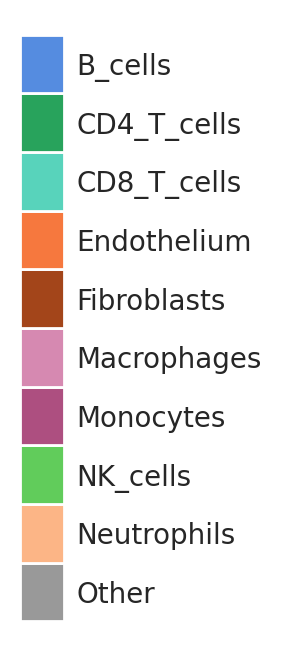

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(0.3,4))

cells_p = { 'B_cells': '#558ce0',
            'CD4_T_cells': '#28a35c',
            'CD8_T_cells': '#58d3bb',
            'Endothelium': '#F6783E',
            'Fibroblasts': '#a3451a',
            'Macrophages': '#d689b1',
            'Monocytes': '#ad4f80',
            'NK_cells': '#61cc5b',
            'Neutrophils': '#FCB586',
            'Other': '#999999',
}

plot_colors(cells_p, ax=axs)
plt.show()

In [34]:
ann = ann.set_index('plot_code')
preds.columns = ann[ann['sample'].isin(preds.columns)].index

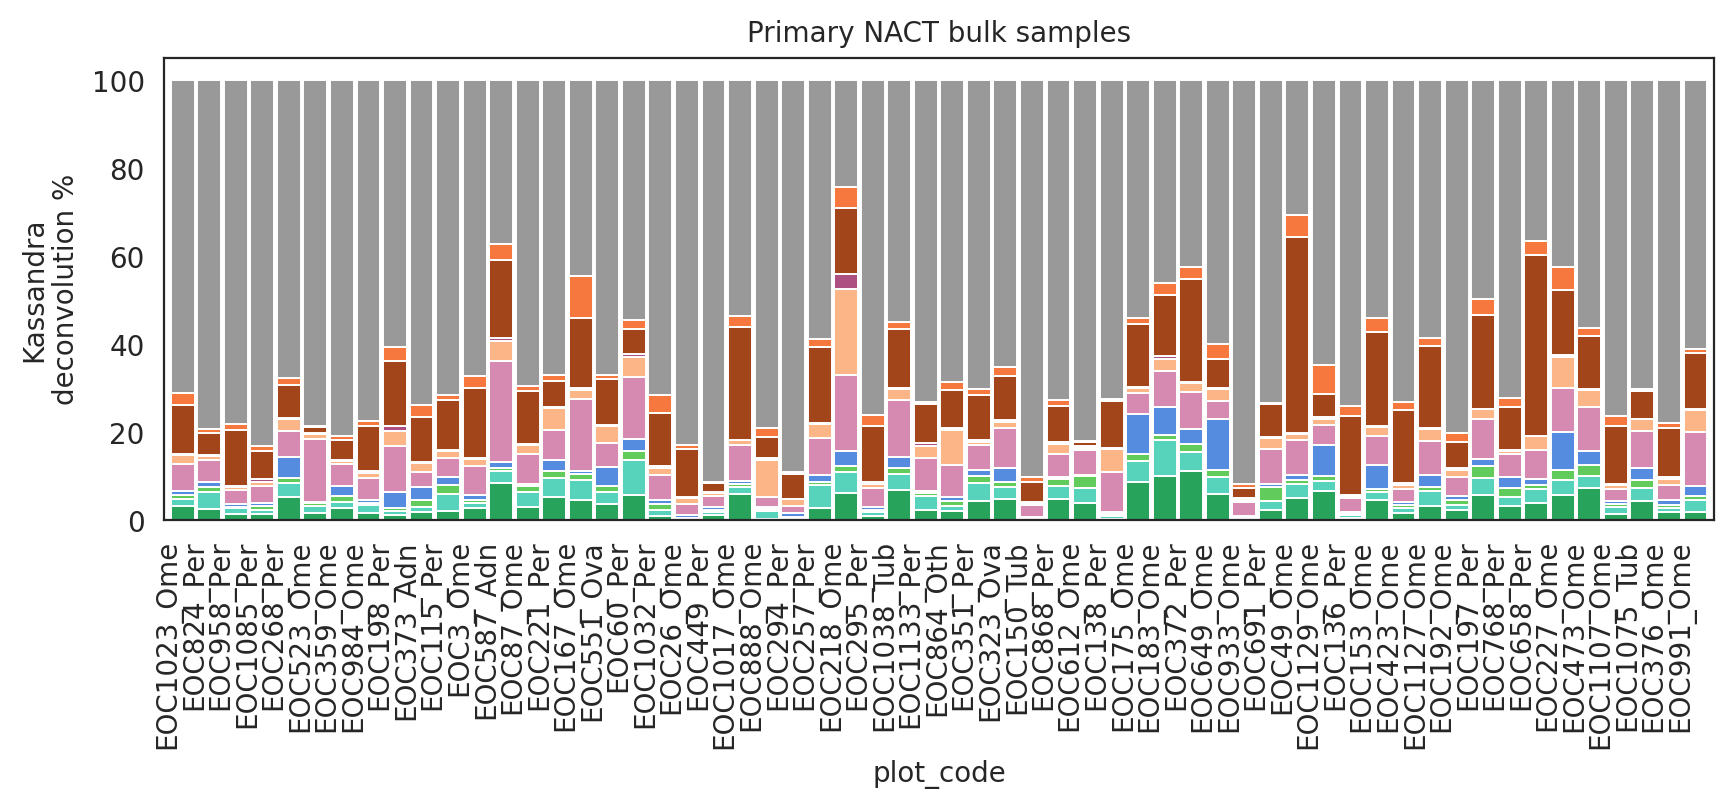

In [35]:
ax = bot_bar_plot(preds[ann.sort_values(by='Status').index].loc[['CD4_T_cells', 'CD8_T_cells',
                             'NK_cells', 'B_cells', 'Macrophages', 
                             'Neutrophils', 'Monocytes', 'Fibroblasts',
                             'Endothelium','Other', ]].T, palette=cells_p,
                  lrot=90, legend=False, xl=False,
                  linewidth=.7, figsize=(10,3))
ax.set_ylabel('Kassandra\ndeconvolution %')
ax.set_title('Primary NACT bulk samples', fontsize=10)
plt.show()

In [36]:
preds = preds.T
preds['Status'] = ann.loc[preds.index, 'Status']
preds.index.name = 'Sample'
preds['sample'] = preds.index
predsmelted=pd.melt(preds, id_vars=['sample', 'Status'], var_name='CellType_Abundance')

predsmelted = predsmelted[predsmelted.CellType_Abundance.isin(['CD4_T_cells', 'CD8_T_cells',
                             'NK_cells', 'B_cells', 'Macrophages_M1', 'Macrophages_M2', 
                             'Neutrophils', 'Monocytes',
                             'Endothelium', 'Fibroblasts', 'Other'])]

/tmp/ipykernel_2764662/2953085665.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=-60)


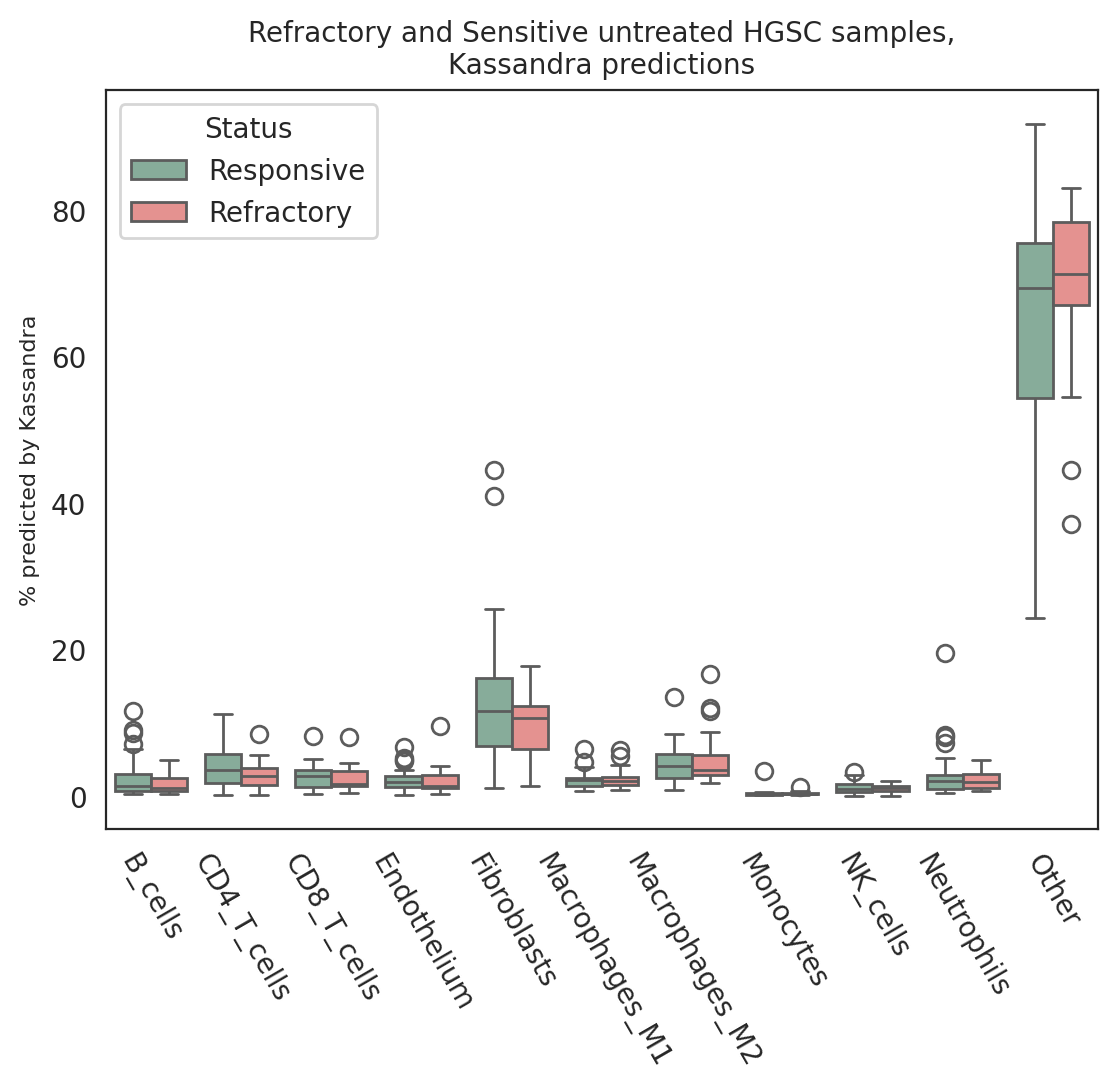

In [37]:
ax = sns.boxplot(data=predsmelted, x='CellType_Abundance', y='value', hue='Status',
                 palette=status_palette,
                 hue_order=['Responsive', 'Refractory']
                )
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=-60)

ax.set_ylabel('% predicted by Kassandra', fontsize=8)
ax.set_xlabel('', fontsize=0)
ax.set_title('Refractory and Sensitive untreated HGSC samples,\nKassandra predictions', fontsize=10)

plt.show()

In [38]:
preds.head(3)

,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,Macrophages_M2,Monocytes,NK_cells,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells,Status,sample
Sample,,,,,,,,,,,,,,,,,,,,,,,,
EOC1023_Ome,0.88,3.24,1.50,0.81,0.70,2.86,11.09,6.54,6.19,2.55,3.65,0.20,0.91,2.06,0.57,71.04,0.31,4.75,1.25,1.99,6.39,13.95,Refractory,EOC1023_Ome
EOC868_Per,0.36,4.78,2.95,1.93,1.02,1.36,8.15,9.81,5.31,2.51,2.80,0.40,1.72,2.26,0.29,72.70,0.07,7.73,1.90,2.88,5.71,9.51,Responsive,EOC868_Per
EOC551_Ova,4.28,3.62,2.68,1.65,1.03,0.93,10.48,12.08,5.47,2.28,3.19,0.24,1.50,3.76,3.71,67.04,0.58,6.30,1.25,2.37,5.71,11.41,Refractory,EOC551_Ova


In [39]:
# Even the nominal (without the correction for multiple hypothesis testing)
# p-values are not significant

for cell_type in preds.columns:
    if cell_type not in ['Status', 'sample']:
        print(cell_type,
              ttest_ind(preds[preds.Status == 'Responsive'][cell_type].values,
                        preds[preds.Status == 'Refractory'][cell_type].values))

B_cells Ttest_indResult(statistic=1.07295941068727, pvalue=0.28789131386952643)
CD4_T_cells Ttest_indResult(statistic=1.2090881565375498, pvalue=0.23170914398457218)
CD8_T_cells Ttest_indResult(statistic=0.12853406633472222, pvalue=0.8981868477722398)
CD8_T_cells_PD1_high Ttest_indResult(statistic=0.42554047105306086, pvalue=0.6720736933589859)
CD8_T_cells_PD1_low Ttest_indResult(statistic=-0.5441194086295427, pvalue=0.5885193081619443)
Endothelium Ttest_indResult(statistic=-0.15761386672778477, pvalue=0.8753280203241249)
Fibroblasts Ttest_indResult(statistic=1.3981982522889504, pvalue=0.16756683016662743)
Lymphocytes Ttest_indResult(statistic=1.0173776191070192, pvalue=0.3133492527273375)
Macrophages Ttest_indResult(statistic=-0.9166525799008903, pvalue=0.36325555197036896)
Macrophages_M1 Ttest_indResult(statistic=-0.5860158010943656, pvalue=0.5602195012654566)
Macrophages_M2 Ttest_indResult(statistic=-0.9703905141274797, pvalue=0.3360246341740891)
Monocytes Ttest_indResult(statistic=

## PRISM

In [40]:
W = pd.read_csv('/mnt/storageBig8/resources/processed_data/HERCULES/rnaseq-decom/2023_11_07/out/W.tsv.gz',
                sep='\t', index_col=0)

In [41]:
# PRISM cell type abundancies
W = pd.read_csv('/mnt/storageBig8/resources/processed_data/HERCULES/rnaseq-decom/2023_11_07/out/W.tsv.gz',
                sep='\t', index_col=0)
W = W.loc[ann['sample'].values]
W.index = ann[ann['sample'].isin(W.index)].index

W = W.loc[ann.index]
W['Status'] = ann.loc[W.index, 'Status']
W.index.name = 'Sample'
W['sample'] = W.index
Wmelted=pd.melt(W, id_vars=['sample', 'Status'], var_name='CellType_Abundance')

Wmelted = Wmelted[Wmelted.CellType_Abundance.isin(['EOC', 'Fibroblast', 'Immune', 'Unknown'])]

/tmp/ipykernel_2764662/3781163536.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=-60)


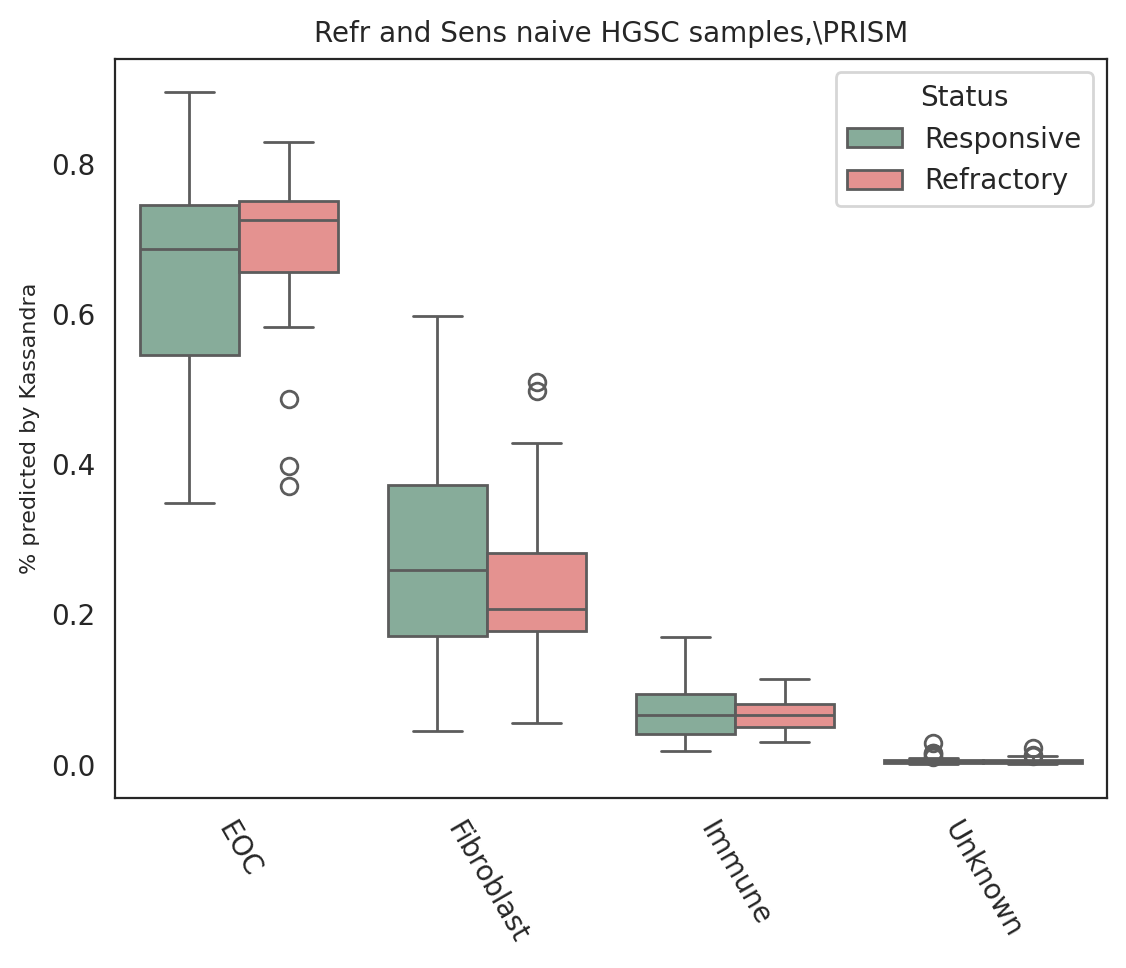

In [42]:
ax = sns.boxplot(data=Wmelted, x='CellType_Abundance', y='value', hue='Status',
                 palette=status_palette,
                 hue_order=['Responsive', 'Refractory']
                )
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=-60)

ax.set_ylabel('% predicted by Kassandra', fontsize=8)
ax.set_xlabel('', fontsize=0)
ax.set_title('Refr and Sens naive HGSC samples,\PRISM', fontsize=10)

plt.show()

In [43]:
# Even the nominal (without the correction for multiple hypothesis testing)
# p-values are not significant

ttest_ind(W[W.Status == 'Refractory']['EOC'].values, W[W.Status == 'Responsive']['EOC'].values)

Ttest_indResult(statistic=0.5821314096293085, pvalue=0.562814588959179)

In [44]:
# Even the nominal (without the correction for multiple hypothesis testing)
# p-values are not significant

ttest_ind(W[W.Status == 'Refractory']['Fibroblast'].values, W[W.Status == 'Responsive']['Fibroblast'].values)

Ttest_indResult(statistic=-0.5373480796113153, pvalue=0.5931560903362564)

In [45]:
# Even the nominal (without the correction for multiple hypothesis testing)
# p-values are not significant

ttest_ind(W[W.Status == 'Refractory']['Immune'].values, W[W.Status == 'Responsive']['Immune'].values)

Ttest_indResult(statistic=-0.2994890871035362, pvalue=0.7656756655940831)

## TCGA subtypes

In [46]:
subtypes = pd.read_csv('/mnt/storageBig8/work/afenteva/RNASEQ/TCGA_subtypes_set1-16.tsv',
                       sep=',', index_col=0)

In [47]:
subtypes = subtypes.loc[ann['sample'].values]
subtypes.index = ann[ann['sample'].isin(subtypes.index)].index
subtypes.head(3)

,consensusOV.subtypes,rf.probs.IMR_consensus,rf.probs.DIF_consensus,rf.probs.PRO_consensus,rf.probs.MES_consensus
plot_code,,,,,
EOC1023_Ome,MES_consensus,0.146,0.208,0.156,0.490
EOC868_Per,DIF_consensus,0.194,0.684,0.054,0.068
EOC551_Ova,PRO_consensus,0.240,0.216,0.398,0.146


In [48]:
ann = ann.join(subtypes.loc[ann.index][['consensusOV.subtypes']])

In [49]:
ann.groupby('Status')['consensusOV.subtypes'].value_counts()

Status      consensusOV.subtypes
Refractory  DIF_consensus            6
            MES_consensus            6
            PRO_consensus            6
            IMR_consensus            2
Responsive  MES_consensus           19
            IMR_consensus            8
            DIF_consensus            6
            PRO_consensus            5
Name: consensusOV.subtypes, dtype: int64

# DecoupleR

## DeSeq2 (DEA: Refractory vs Sensitive/Responsive)

In [50]:
EOC_study = EOC[ann['sample'].values]
EOC_study.columns = ann[ann['sample'].isin(EOC_study.columns)].index
EOC_study.head(3)

plot_code,EOC1023_Ome,EOC868_Per,EOC551_Ova,EOC60_Per,EOC1133_Per,EOC26_Ome,EOC218_Ome,EOC1032_Per,EOC167_Ome,EOC183_Ome,EOC376_Ome,EOC1129_Ome,EOC372_Per,EOC423_Ome,EOC87_Ome,EOC295_Per,EOC587_Adn,EOC649_Ome,EOC933_Ome,EOC691_Per,EOC49_Ome,EOC3_Ome,EOC136_Per,EOC153_Ome,EOC1127_Ome,EOC115_Per,EOC192_Ome,EOC197_Per,EOC991_Ome,EOC658_Per,EOC227_Ome,EOC473_Ome,EOC1107_Ome,EOC1075_Tub,EOC373_Adn,EOC198_Per,EOC175_Ome,EOC612_Ome,EOC449_Per,EOC1017_Ome,EOC888_Ome,EOC294_Per,EOC257_Per,EOC984_Ome,EOC359_Ome,EOC523_Ome,EOC138_Per,EOC1038_Tub,EOC268_Per,EOC864_Oth,EOC351_Per,EOC323_Ova,EOC1085_Per,EOC958_Per,EOC150_Tub,EOC824_Per,EOC768_Per,EOC221_Per
geneName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OR4F5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053681,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FO538757.2,0.000000,0.000000,0.000000,0.000000,0.00000,0.033841,0.000001,0.000000,0.000000,0.000000,0.065502,0.231109,0.197836,0.00000,0.000000,0.000000,0.000000,0.000000,0.000001,1.415163,0.001251,0.001143,0.000000,0.001437,0.018237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007299,0.63842,0.000000,0.000000,0.000138,0.699633,0.000000,0.000202,0.000000,0.000000,5.603891e-07,0.224339,0.000000,0.000000,0.000000,0.406058,0.000000,0.000000,0.000000,0.000000,2.881737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000057
FO538757.1,400.680374,522.598615,459.327441,396.767891,504.19781,694.373747,320.448395,487.080023,586.003515,313.735874,599.369427,513.613648,411.892608,220.50946,155.926368,409.612156,159.050906,735.497241,1095.154447,709.783403,90.897592,618.902316,211.620097,909.248267,717.947035,431.891681,259.379142,391.773365,453.893004,283.450703,458.891139,360.024590,872.04605,103.448002,314.721733,152.838901,179.409133,156.028845,271.418811,197.423906,175.202146,3.954338e+02,314.067222,149.494542,484.386028,223.461979,309.955968,485.997752,514.262719,485.439896,335.063924,322.756925,294.154945,511.792402,160.197214,92.087861,98.144181,144.985255


In [51]:
# Transform to AnnData object

adata = AnnData(np.round(EOC_study[ann.index].T), dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 58 × 20361

In [52]:
# Process treatment information
adata.obs['condition'] = [ann.loc[sample_id, 'Status'] for sample_id in adata.obs.index]
adata.obs['patient'] = [ann.loc[sample_id, 'patient'] for sample_id in adata.obs.index]
adata.obs['tissue'] = [ann.loc[sample_id, 'tissue'] for sample_id in adata.obs.index]
adata.obs['HRD'] = [ann.loc[sample_id, 'SBS3'] for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = adata.obs.index

In [53]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition',
                          min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 58 × 14709
    obs: 'condition', 'patient', 'tissue', 'HRD', 'sample_id'

In [54]:
# Build the DESeq2 object
dds = DeseqDataSet(
    adata=adata,
    design_factors=['HRD', 'condition'],
    # design_factors=['condition'],
    refit_cooks=True,
    n_cpus=8, ref_level = ['condition', 'Responsive']
)

In [55]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 15.14 seconds.

Fitting dispersion trend curve...
... done in 5.09 seconds.

Fitting MAP dispersions...
... done in 16.02 seconds.

Fitting LFCs...
... done in 1.77 seconds.

Refitting 504 outliers.

Fitting dispersions...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 0.14 seconds.

Fitting LFCs...
... done in 0.10 seconds.



In [56]:
G = pd.read_csv('/mnt/storageBig8/resources/processed_data/HERCULES/rnaseq-decom/2023_03_10/out/G.tsv.gz',
                sep='\t', index_col=0)
W = pd.read_csv('/mnt/storageBig8/resources/processed_data/HERCULES/rnaseq-decom/2023_03_10/out/W.tsv.gz',
                sep='\t', index_col=0)

nf_bulk = G.loc['bulk_gains']*W['EOC']
nf_bulk = nf_bulk / np.exp(np.mean(np.log(nf_bulk)))


nf_bulk_II = nf_bulk.loc[ann['sample'].values]
nf_bulk_II.index = ann[ann['sample'].isin(nf_bulk_II.index)].index
dds.obsm['size_factors'] = nf_bulk_II.values

In [57]:
stat_res = DeseqStats(dds,
                      contrast=["condition",
                                'Refractory',
                                'Responsive'], n_cpus=8)

In [58]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 1.04 seconds.

Log2 fold change & Wald test p-value: condition Refractory vs Responsive


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
geneName,,,,,,
FO538757.1,371.719696,-0.027626,0.200496,-0.137788,0.890408,0.988893
SAMD11,278.853394,0.167304,0.505277,0.331114,0.740559,0.983293
NOC2L,1594.377319,-0.042228,0.183169,-0.230544,0.817669,0.985521
KLHL17,157.060883,-0.215669,0.207786,-1.037939,0.299299,0.937632
PLEKHN1,29.591730,0.420247,0.305293,1.376538,0.168655,0.878104
...,...,...,...,...,...,...
MT-ND4L,1853.098511,0.254825,0.322238,0.790799,0.429061,0.961289
MT-ND4,4746.125488,0.473570,0.342480,1.382768,0.166736,0.876918
MT-ND5,2139.694824,0.564986,0.303629,1.860777,0.062776,0.766824


In [59]:
# Extract results
results_df = stat_res.results_df

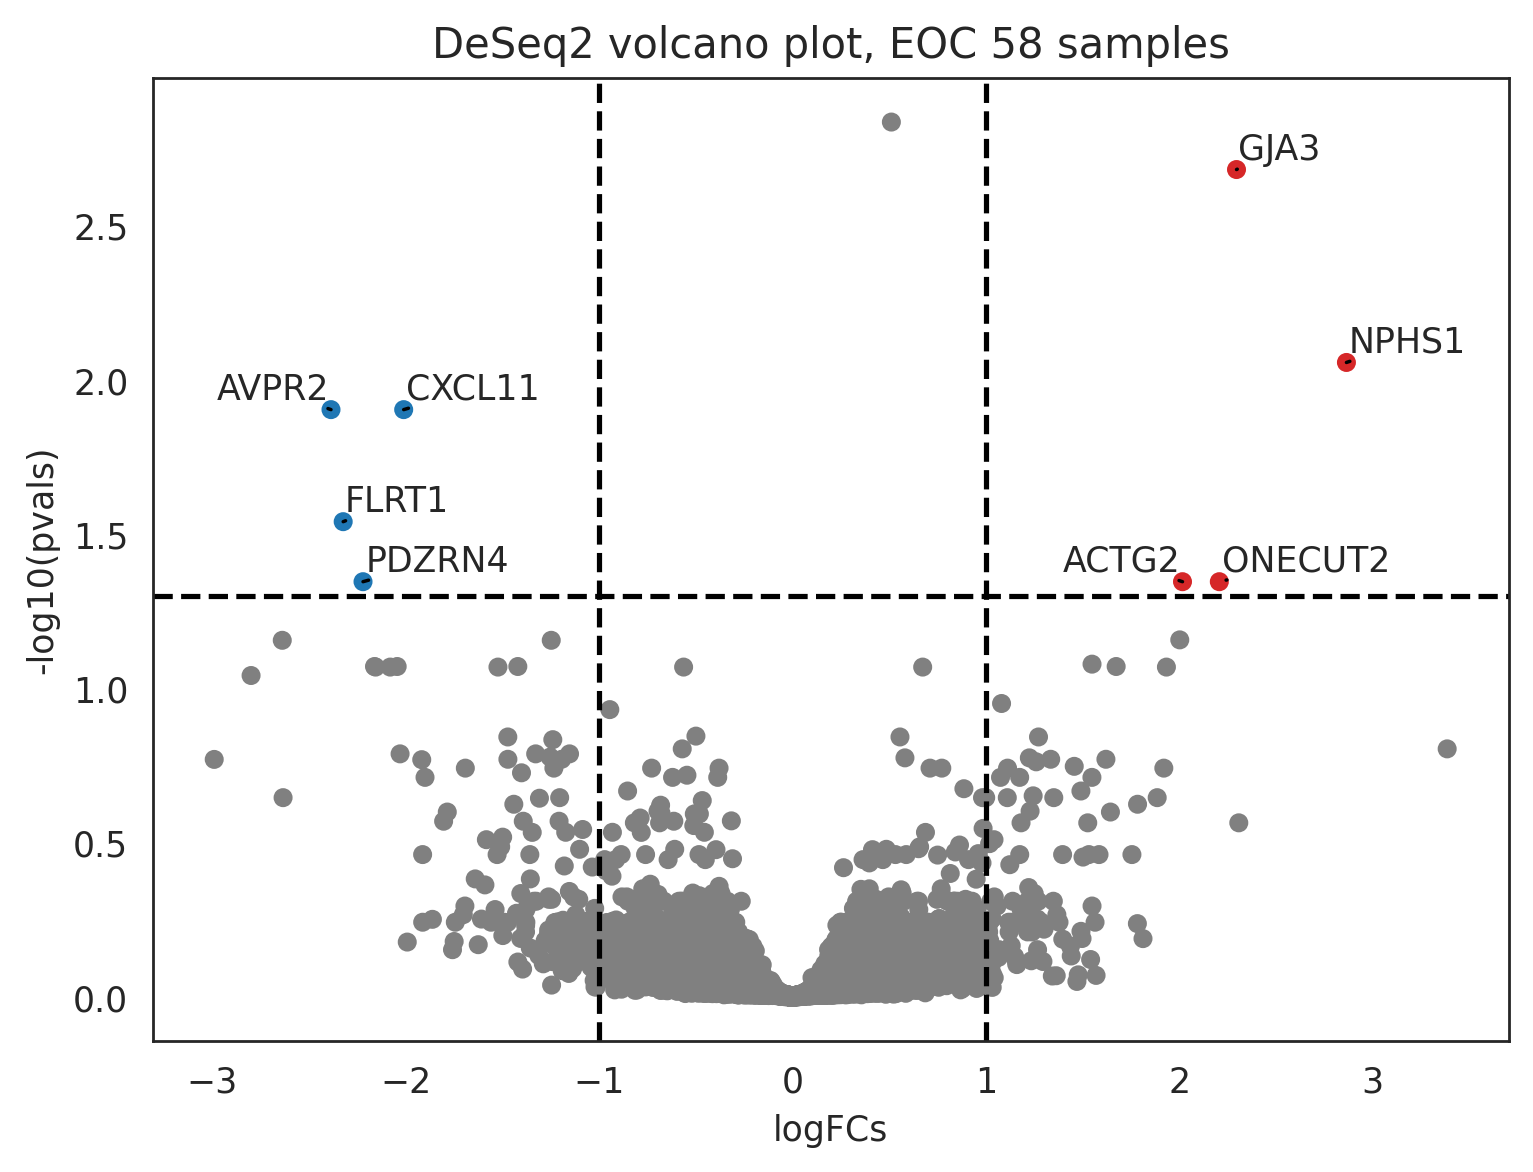

In [60]:
dc.plot_volcano_df(results_df, x='log2FoldChange',
                   y='padj', top=25, dpi=250, lFCs_thr=1., sign_limit=6, sign_thr=0.05,
                  
                  )
plt.title('DeSeq2 volcano plot, EOC 58 samples')

plt.show()

In [61]:
mat = results_df[['stat']].T.rename(index={'stat': 'Refractory.vs.Responsive'})
mat

geneName,FO538757.1,SAMD11,NOC2L,KLHL17,PLEKHN1,HES4,ISG15,AGRN,C1orf159,TTLL10,TNFRSF18,SDF4,B3GALT6,FAM132A,UBE2J2,SCNN1D,ACAP3,PUSL1,CPSF3L,CPTP,TAS1R3,DVL1,MXRA8,AURKAIP1,CCNL2,MRPL20,ANKRD65,VWA1,ATAD3C,ATAD3B,ATAD3A,TMEM240,SSU72,FNDC10,MIB2,MMP23B,CDK11B,SLC35E2B,CDK11A,SLC35E2,...,ATP6AP1,GDI1,FAM50A,PLXNA3,LAGE3,UBL4A,SLC10A3,FAM3A,G6PD,IKBKG,GAB3,DKC1,MPP1,F8,F8A1,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,F8A3,TMLHE,SPRY3,VAMP7,IL9R,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
Refractory.vs.Responsive,-0.137788,0.331114,-0.230544,-1.037939,1.376538,1.455756,-3.406333,0.466531,-0.175373,0.985173,1.279272,0.015968,0.582067,0.830588,0.38535,0.75361,0.288182,1.297834,0.074892,0.211352,1.778271,0.540837,1.894681,-0.268795,0.770592,-1.153589,1.800585,0.624389,1.708235,-0.157087,0.014641,0.43378,0.258155,0.779608,-0.139742,2.375373,0.252231,0.738798,0.274121,-0.415961,...,-1.564481,-0.084339,0.003616,1.019127,-0.126256,-1.545905,-1.109308,-1.3122,-1.072892,-0.984495,0.140298,-1.752043,-1.303166,-0.963175,-1.845359,-0.600404,-1.454482,-1.319849,-2.357302,-1.057821,-1.065668,-0.5665,-0.013194,-0.387945,-0.44818,-2.075538,-1.137905,1.688957,1.77142,0.822211,0.667498,1.616114,1.473395,0.670292,0.702616,0.790799,1.382768,1.860777,0.203114,1.934576


In [62]:
refr_samples = ann[ann.Status == 'Refractory'].index
resp_samples = ann[ann.Status == 'Responsive'].index

## Transcriptional factor activity

In [63]:
# Retrieve CollecTRI gene regulatory network
collectri.head(3)

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795


In [64]:
collectri.target.nunique()

6692

In [65]:
collectri.source.nunique()

1186

In [66]:
collectri.target.nunique()

6692

In [67]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat,
                               net=collectri,
                               verbose=True, min_n=10)
tf_acts

Running ulm on mat with 1 samples and 14709 targets for 493 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID4B,ARNT,ARX,ASCL1,ATF1,ATF2,ATF3,ATF4,ATF5,ATF6,BACH1,BARX2,BCL11B,BCL3,BCL6,BHLHA15,BHLHE40,BHLHE41,BMAL1,BRCA1,BRD4,CDX1,CDX2,CEBPA,CEBPB,CEBPD,CEBPE,CEBPG,CEBPZ,CIITA,CLOCK,CREB1,CREB3,CREB5,...,TRPS1,TTF1,TWIST1,TWIST2,USF1,USF2,VDR,VHL,VSX2,WT1,XBP1,YBX1,YBX3,YY1,ZBED1,ZBTB16,ZBTB17,ZBTB33,ZBTB4,ZBTB7A,ZBTB7B,ZEB1,ZEB2,ZFP42,ZFPM1,ZFPM2,ZGLP1,ZIC1,ZKSCAN7,ZNF143,ZNF148,ZNF331,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF699,ZNF804A,ZNF91
Refractory.vs.Responsive,2.409828,1.529845,0.764089,1.04644,1.597948,2.486603,-4.394705,1.260225,0.520544,1.309907,0.339975,0.314597,1.432257,1.387489,0.681598,0.516708,0.525783,0.100733,-0.064499,-0.047952,0.809942,-0.26628,0.413875,-0.380391,0.928462,-1.207684,0.126166,-0.866854,-1.578711,-0.523999,-0.157357,0.020854,-0.497272,0.866674,1.528258,-1.486832,0.86293,1.069795,0.583573,-0.582992,...,-1.324181,1.358944,-0.186788,-0.465815,-0.738766,-0.070746,0.071032,-0.335069,-1.329211,1.576296,-0.291751,0.364365,-0.049679,0.754233,-0.091513,-1.058714,0.837144,0.319215,-0.17768,-0.521516,-0.365001,-0.008387,-0.187009,-1.390221,-0.664712,-0.224771,-1.071662,1.170499,0.050732,-0.162191,0.255502,-0.224342,-1.771613,2.083454,0.376871,0.276001,-0.180863,-1.890449,0.212787,0.53241


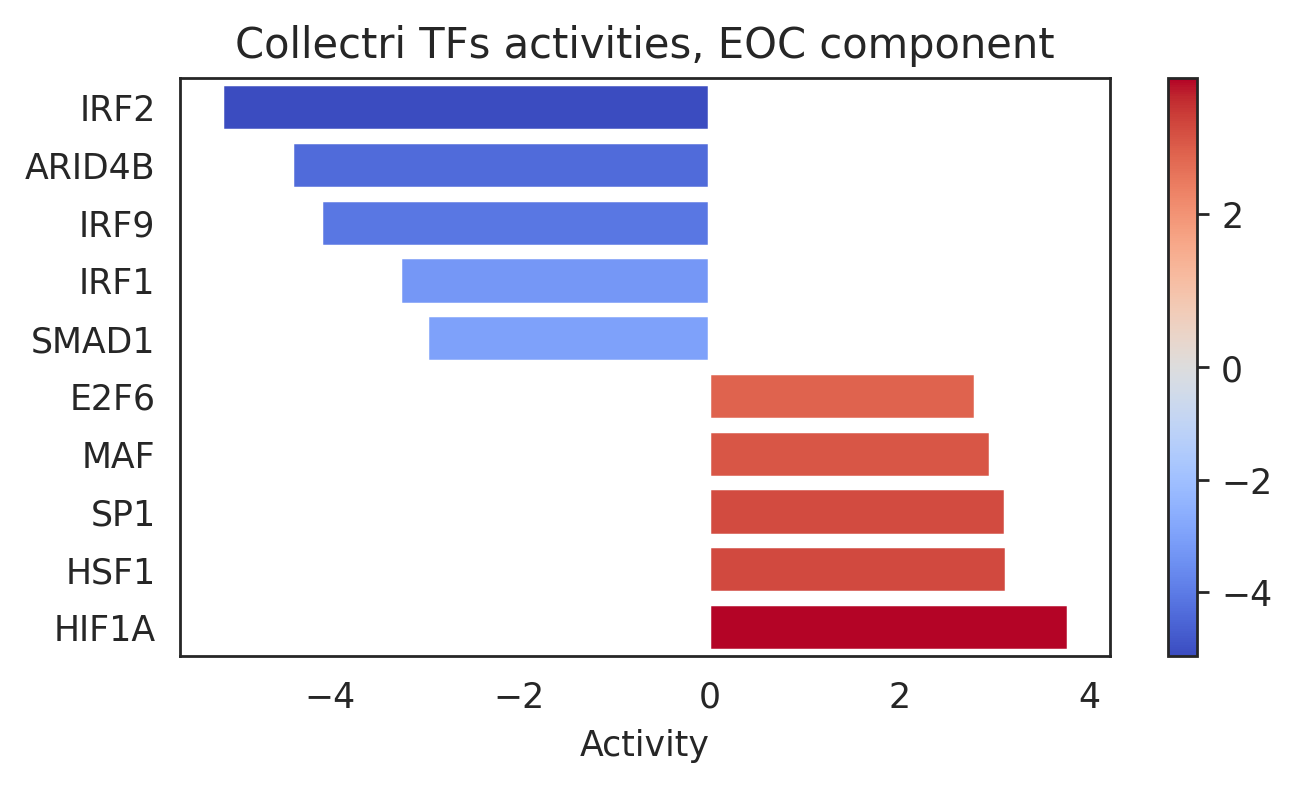

In [68]:
dc.plot_barplot(tf_acts, 'Refractory.vs.Responsive', top=10, vertical=True, figsize=(6,3)
                , dpi=250
               )
plt.title('Collectri TFs activities, EOC component')


plt.show()

In [69]:
pd.concat([tf_acts.T.sort_values('Refractory.vs.Responsive').tail(5), 
           tf_acts.T.sort_values('Refractory.vs.Responsive').head(5)]).sort_values('Refractory.vs.Responsive')

,Refractory.vs.Responsive
IRF2,-5.131654
ARID4B,-4.394705
IRF9,-4.094589
IRF1,-3.256536
SMAD1,-2.973366
E2F6,2.798903
MAF,2.953300
SP1,3.111703
HSF1,3.128544
HIF1A,3.774882


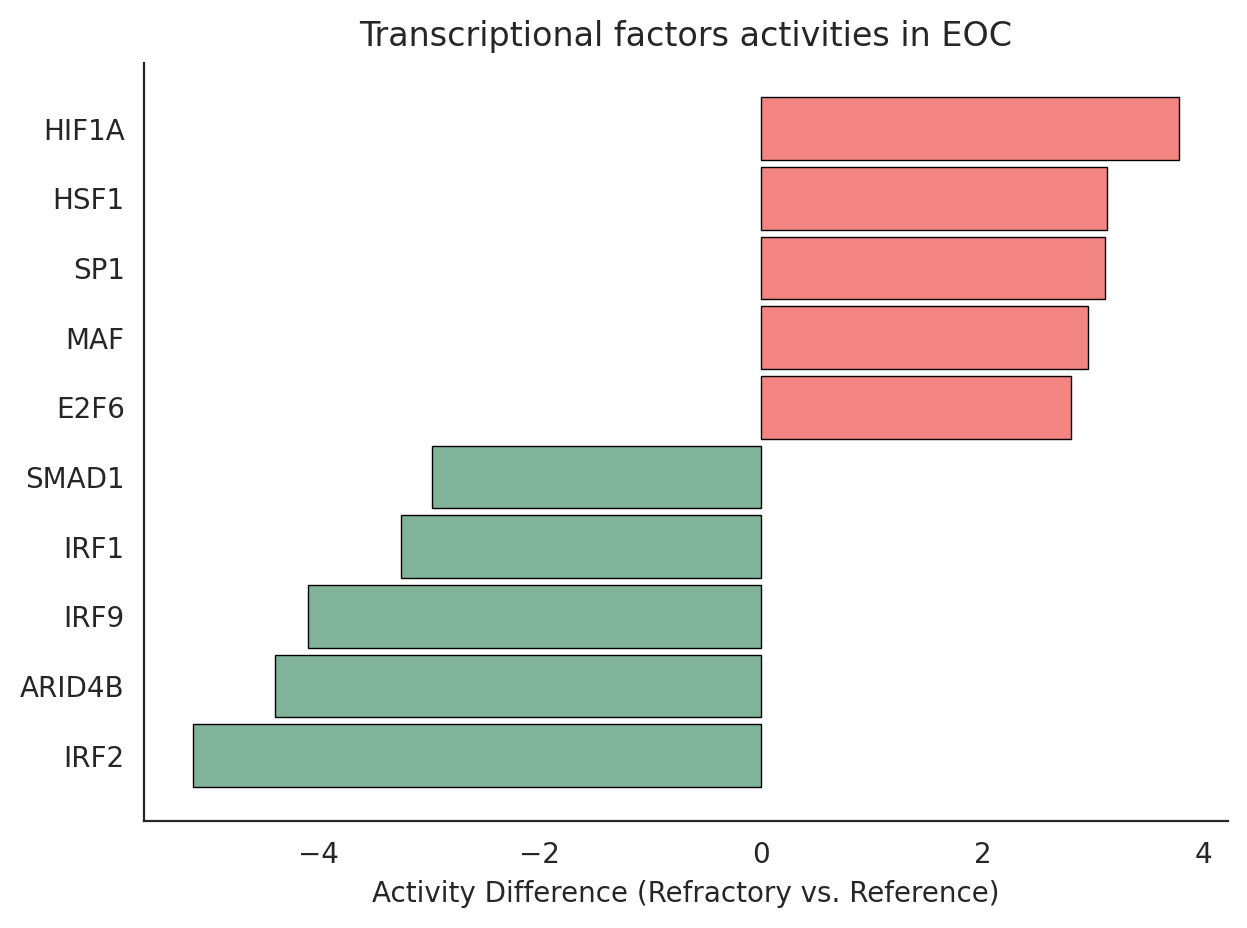

In [70]:
# Create a new figure and axis object
fig, ax = plt.subplots()  # Adjust the figure size as needed

# Sort the dataframe by the activity score for better visualization
data_sorted = pd.concat([tf_acts.T.sort_values('Refractory.vs.Responsive').tail(5), 
                         tf_acts.T.sort_values('Refractory.vs.Responsive').head(5)]).\
                                sort_values('Refractory.vs.Responsive')
data_sorted['TF'] = data_sorted.index

colors = ['#f28482' if x > 0 else '#81b29a' for x in data_sorted['Refractory.vs.Responsive']]
# Plotting the data
ax.barh(data_sorted['TF'],
        data_sorted['Refractory.vs.Responsive'], 
        color=colors, height=0.9,
        edgecolor='black', linewidth=0.5)  # You can choose your color

# Set the title and labels
ax.set_title('Transcriptional factors activities in EOC')
ax.set_xlabel('Activity Difference (Refractory vs. Reference)')

# Customizing the plot to replicate the style and font as closely as possible
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Removing spines
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

# Adjust the layout
plt.tight_layout()

plt.show()

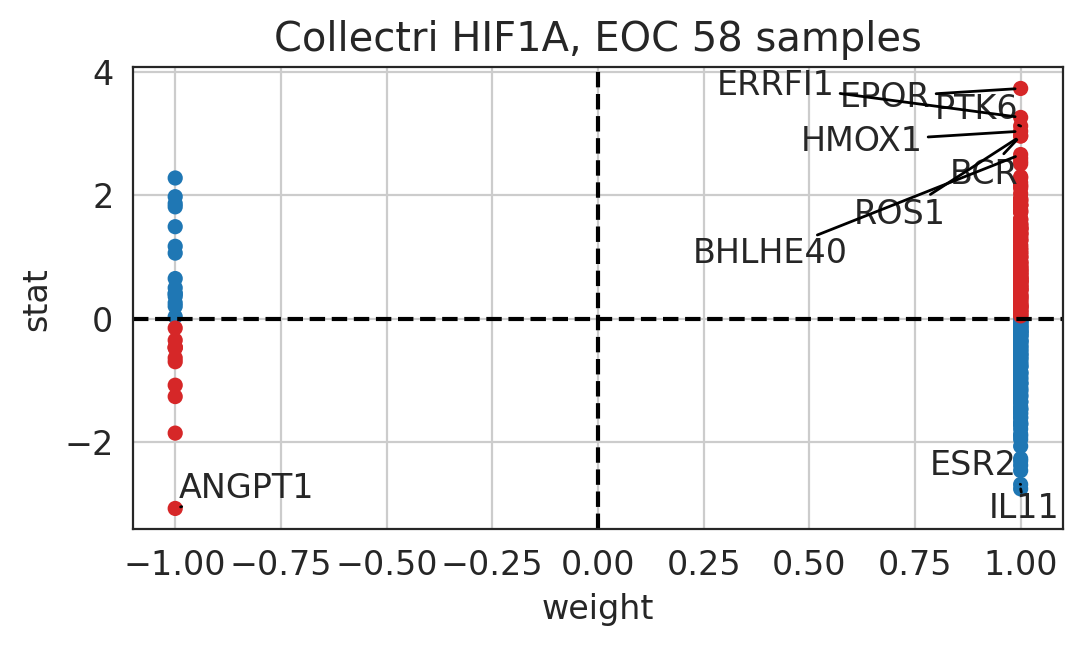

In [71]:
dc.plot_targets(results_df, stat='stat', source_name='HIF1A',
                net=collectri, top=10, figsize=(6,3),
               dpi=200
               )
plt.title('Collectri HIF1A, EOC 58 samples')

plt.show()

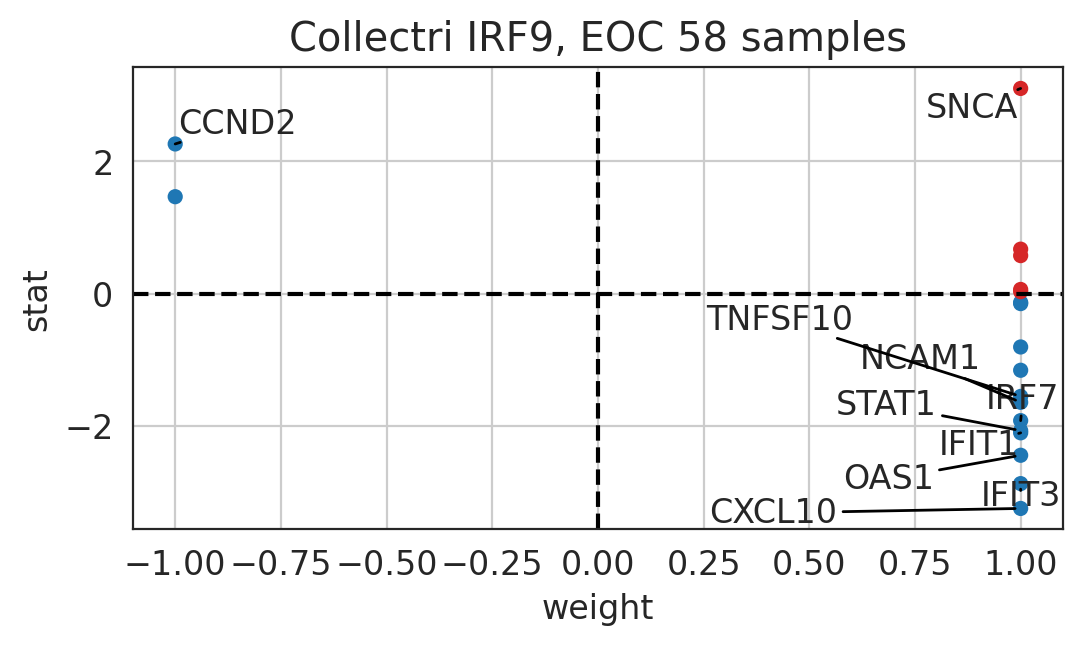

In [72]:
dc.plot_targets(results_df, stat='stat', source_name='IRF9',
                net=collectri, top=10, figsize=(6,3),
               dpi=200
               )
plt.title('Collectri IRF9, EOC 58 samples')

plt.show()

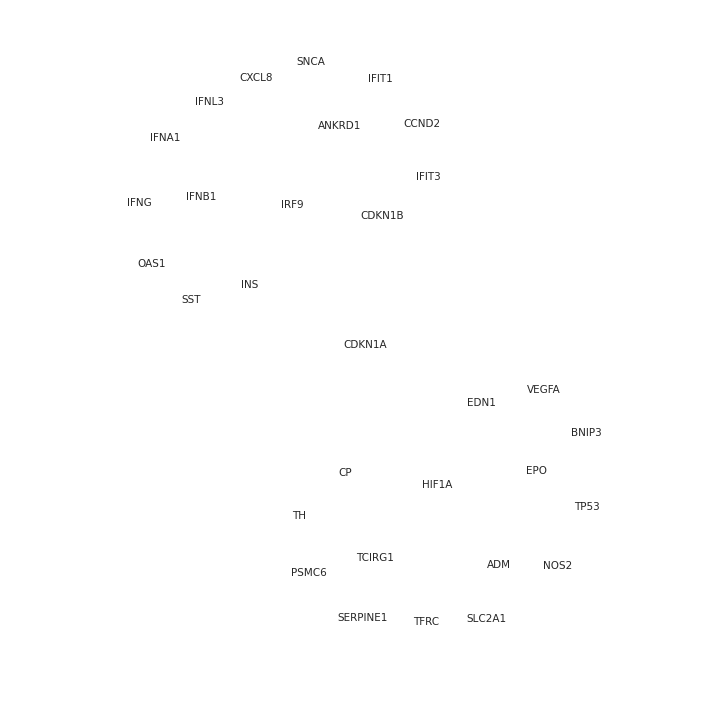

In [77]:
dc.plot_network(
    net=collectri,
    n_sources=['HIF1A', 'IRF9', 'IRF9'],
    n_targets=15,
    node_size=100,
    s_cmap='white',
    t_cmap='white',
    c_pos_w='darkgreen',
    c_neg_w='darkred',
    figsize=(5, 5)
)
plt.show()

## Pathway activity inference

In [72]:
# Retrieve PROGENy model weights
progeny.head(3)

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44


In [73]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True,)
pathway_acts

Running mlm on mat with 1 samples and 14709 targets for 14 sources.


,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
Refractory.vs.Responsive,0.760364,-0.706909,0.907061,4.657811,-18.835081,1.83068,0.396396,0.981565,-3.433927,-0.223382,0.626913,0.004182,-0.383858,1.105594


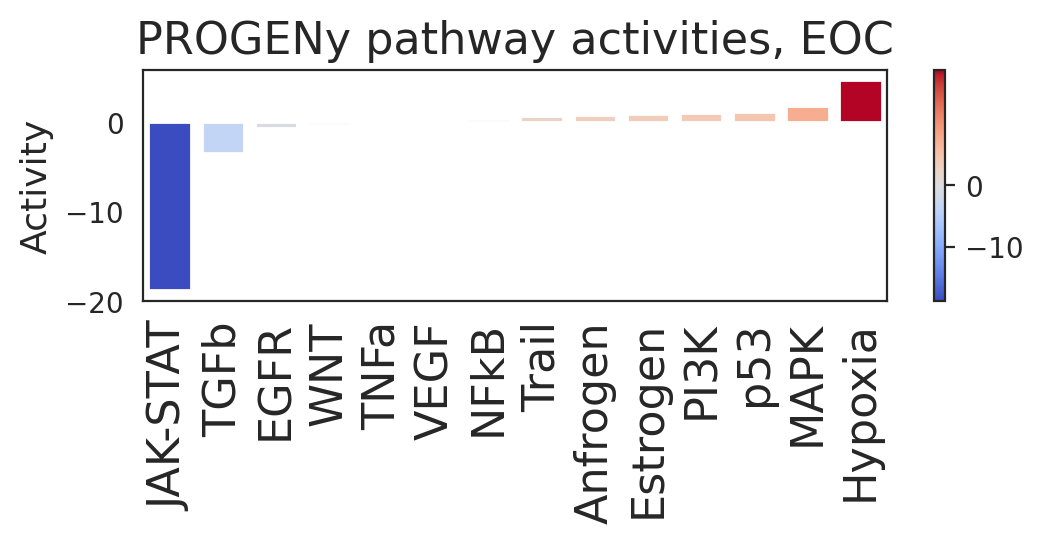

In [74]:
# plt.style.use('ggplot')
fig = dc.plot_barplot(pathway_acts, 'Refractory.vs.Responsive',
                top=25, vertical=False, dpi=200, figsize=(6,1.5),)
plt.title('PROGENy pathway activities, EOC', fontsize=16)
plt.xticks(ticks=range(14), labels=['JAK-STAT', 'TGFb', 'EGFR', 'WNT', 'TNFa',
                 'VEGF', 'NFkB', 'Trail', 'Anfrogen', 'Estrogen',
                 'PI3K', 'p53', 'MAPK', 'Hypoxia'], fontsize=16)
plt.ylabel('Activity', fontsize=13)

plt.show()

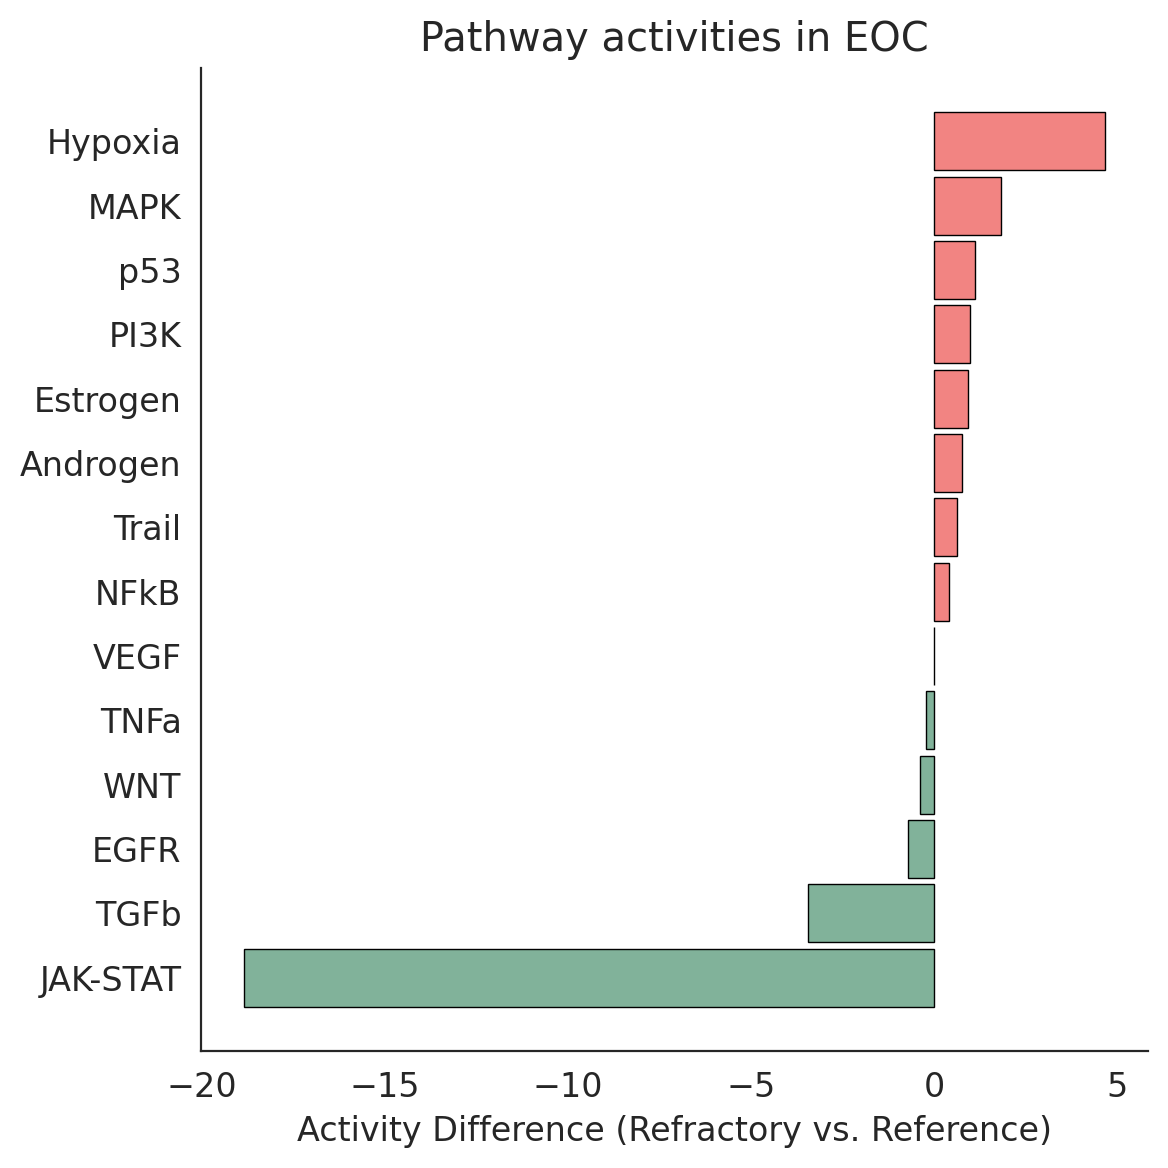

In [138]:
# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the figure size as needed

# Sort the dataframe by the activity score for better visualization
data_sorted = pathway_acts.T.sort_values('Refractory.vs.Responsive')
data_sorted['Pathway'] = data_sorted.index

colors = ['#f28482' if x > 0 else '#81b29a' for x in data_sorted['Refractory.vs.Responsive']]
# Plotting the data
ax.barh(data_sorted['Pathway'],
        data_sorted['Refractory.vs.Responsive'], 
        color=colors, height=0.9,
        edgecolor='black', linewidth=0.5)  # You can choose your color

# Set the title and labels
ax.set_title('Pathway activities in EOC')
ax.set_xlabel('Activity Difference (Refractory vs. Reference)')

# Customizing the plot to replicate the style and font as closely as possible
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Removing spines
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)

# Adjust the layout
plt.tight_layout()

plt.show()

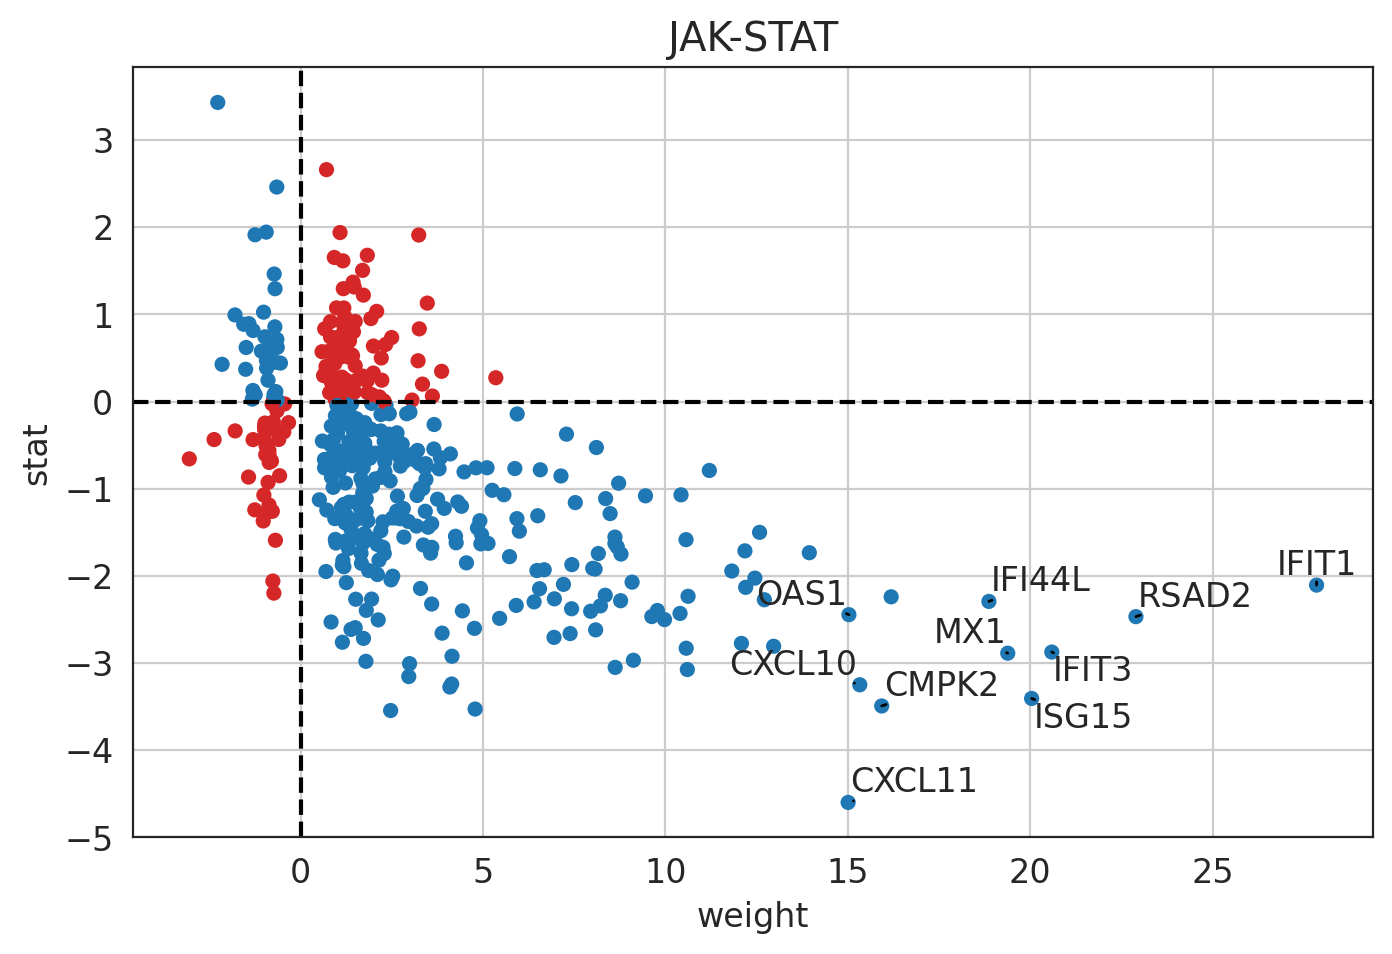

In [139]:
f1 = dc.plot_targets(results_df, stat='stat',
                source_name='JAK-STAT', net=progeny,
                top=10, dpi=200, figsize=(8,5), return_fig=True)

plt.show()

## Per-sample pathway scores

In [76]:
adata.raw = adata
# adata.raw = EOC_tmm

In [77]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running mlm on mat with 58 samples and 14709 targets for 14 sources.


In [78]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 58 × 14709
    obs: 'condition', 'patient', 'tissue', 'HRD', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'

In [79]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 58 × 14
    obs: 'condition', 'patient', 'tissue', 'HRD', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

In [82]:
ann['Hypoxia'] = acts.obsm['mlm_estimate']['Hypoxia']
ann['JAK-STAT'] = acts.obsm['mlm_estimate']['JAK-STAT']

# Functional enrichment of biological terms

In [152]:
import gseapy as gp

In [158]:
EOC_tmm_study = EOC_tmm[ann['sample'].values]
EOC_tmm_study.columns = ann[ann['sample'].isin(EOC_tmm_study.columns)].index
EOC_tmm_study.head(5)

plot_code,EOC1023_Ome,EOC868_Per,EOC551_Ova,EOC60_Per,EOC1133_Per,EOC26_Ome,EOC218_Ome,EOC1032_Per,EOC167_Ome,EOC183_Ome,EOC376_Ome,EOC1129_Ome,EOC372_Per,EOC423_Ome,EOC87_Ome,EOC295_Per,EOC587_Adn,EOC649_Ome,EOC933_Ome,EOC691_Per,EOC49_Ome,EOC3_Ome,EOC136_Per,EOC153_Ome,EOC1127_Ome,EOC115_Per,EOC192_Ome,EOC197_Per,EOC991_Ome,EOC658_Per,EOC227_Ome,EOC473_Ome,EOC1107_Ome,EOC1075_Tub,EOC373_Adn,EOC198_Per,EOC175_Ome,EOC612_Ome,EOC449_Per,EOC1017_Ome,EOC888_Ome,EOC294_Per,EOC257_Per,EOC984_Ome,EOC359_Ome,EOC523_Ome,EOC138_Per,EOC1038_Tub,EOC268_Per,EOC864_Oth,EOC351_Per,EOC323_Ova,EOC1085_Per,EOC958_Per,EOC150_Tub,EOC824_Per,EOC768_Per,EOC221_Per
geneName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.051444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FO538757.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.034455,9.725842e-07,0.000000,0.000000,0.000000,0.062935,0.203117,0.180691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,1.509039,0.001124,0.001072,0.000000,0.001276,0.017395,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.006995,0.569821,0.000000,0.000000,0.000139,0.614678,0.000000,0.000192,0.000000,0.000000,5.501710e-07,0.208925,0.000000,0.000000,0.000000,0.403311,0.000000,0.000000,0.000000,0.000000,2.756804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000054
FO538757.1,400.697904,513.147493,428.065395,362.914340,520.941531,706.963497,2.970956e+02,438.570993,525.802600,262.134586,575.879072,451.403423,376.195720,209.702144,156.691768,432.416263,139.621770,753.909384,1115.298106,756.867243,81.668693,580.227583,214.399707,807.493320,684.827767,379.346553,265.8357,368.690848,443.992650,256.669388,415.975017,345.022719,778.343535,126.576406,267.014426,154.173751,157.623922,190.347971,258.159674,172.797187,150.074984,3.882235e+02,292.487744,146.566762,455.494644,235.952815,307.859256,437.159223,460.766998,453.042774,341.117289,308.764346,324.247442,474.350544,151.999543,95.731726,92.838360,136.021776
OR4F29,0.000000,0.081478,0.549185,0.565796,0.000000,0.000000,0.000000e+00,0.598811,0.285428,0.356471,0.001946,0.043993,0.236853,0.000000,0.714367,0.000000,0.038299,1.136910,3.088332,0.000000,0.703179,0.218001,0.463354,0.816320,0.000000,1.437918,0.0000,0.000066,0.392574,0.131869,0.025913,0.049037,0.114765,0.127692,0.255391,0.333578,0.749405,0.290371,1.678348,0.000000,0.411113,1.269627e-03,0.088548,0.039791,0.000000,0.312014,0.000000,0.000000,0.765248,0.122943,1.185126,0.359541,0.000000,1.134267,0.251374,0.517961,0.133297,0.313337
OR4F16,0.000000,0.081478,0.549185,0.565796,0.000000,0.000000,0.000000e+00,0.598811,0.285428,0.356471,0.001946,0.043993,0.236853,0.000000,0.714367,0.000000,0.038299,1.136910,3.088332,0.000000,0.703179,0.218001,0.463354,0.816320,0.000000,1.437918,0.0000,0.000066,0.392574,0.131869,0.025913,0.049037,0.114765,0.127692,0.255391,0.333578,0.749405,0.290371,1.678348,0.000000,0.411113,1.269627e-03,0.088548,0.039791,0.000000,0.312014,0.000000,0.000000,0.765248,0.122943,1.185126,0.359541,0.000000,1.134267,0.251374,0.517961,0.133297,0.313337


In [161]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name
gs_res = gp.gsea(data=EOC_tmm_study[ann.index], # or data='./P53_resampling_data.txt'
                 gene_sets='MSigDB_Hallmark_2020', # or enrichr library names
                 # gene_sets='WikiPathways_2019_Human',
                 cls=ann.Status, # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='t_test',
                 threads=1, seed= 7, max_size=500)

In [165]:
gs_res.res2d.sort_values('NES')[:10]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Interferon Gamma Response,-0.587282,-1.872619,0.029297,0.130933,0.048241,128/198,29.25%,LAP3;ISG15;IFI35;CXCL11;DDX58;CD38;PARP12;GBP4...
1,gsea,Interferon Alpha Response,-0.664506,-1.827519,0.051485,0.096477,0.070352,63/95,15.43%,LAP3;ISG15;IFI35;CXCL11;PARP12;GBP4;CXCL10;EPS...
2,gsea,TGF-beta Signaling,-0.473208,-1.489841,0.065259,0.888393,0.478392,26/54,29.11%,ID1;TGIF1;CDK9;PPM1A;FNTA;XIAP;SKIL;NOG;SMAD1;...
3,gsea,Fatty Acid Metabolism,-0.403195,-1.445124,0.073665,0.900596,0.529648,85/156,41.60%,BMPR1B;UBE2L6;GRHPR;ALAD;PSME1;IDH1;ALDH9A1;HS...
4,gsea,Xenobiotic Metabolism,-0.348138,-1.335606,0.087031,1.0,0.658291,100/195,42.90%,FMO3;LPIN2;ACOX3;GCH1;CROT;CYB5A;IDH1;TYR;ALDH...
5,gsea,UV Response Up,-0.346392,-1.279589,0.149912,1.0,0.710553,62/155,32.41%,PTPRD;TAP1;GRPEL1;CNP;PRPF3;EIF5;PARP2;GCH1;PP...
6,gsea,Bile Acid Metabolism,-0.326286,-1.269932,0.128039,1.0,0.719598,66/111,49.69%,CROT;IDH1;PEX16;HSD17B6;SLC27A2;ALDH9A1;SLC27A...
7,gsea,Pperoxisome,-0.349084,-1.255531,0.19469,1.0,0.731658,59/104,45.54%,ESR2;IDH1;SLC27A2;ALDH9A1;ISOC1;ACSL4;PEX11B;C...
8,gsea,heme Metabolism,-0.338477,-1.252654,0.197417,1.0,0.732663,89/191,39.40%,BPGM;LPIN2;ACP5;DAAM1;ALAD;NARF;XK;MOCOS;UBAC1...
9,gsea,Myc Targets V1,-0.408035,-1.250905,0.239923,1.0,0.733668,139/196,48.83%,CLNS1A;PSMD1;PSMD3;VDAC3;DHX15;CCT3;HSPD1;ERH;...


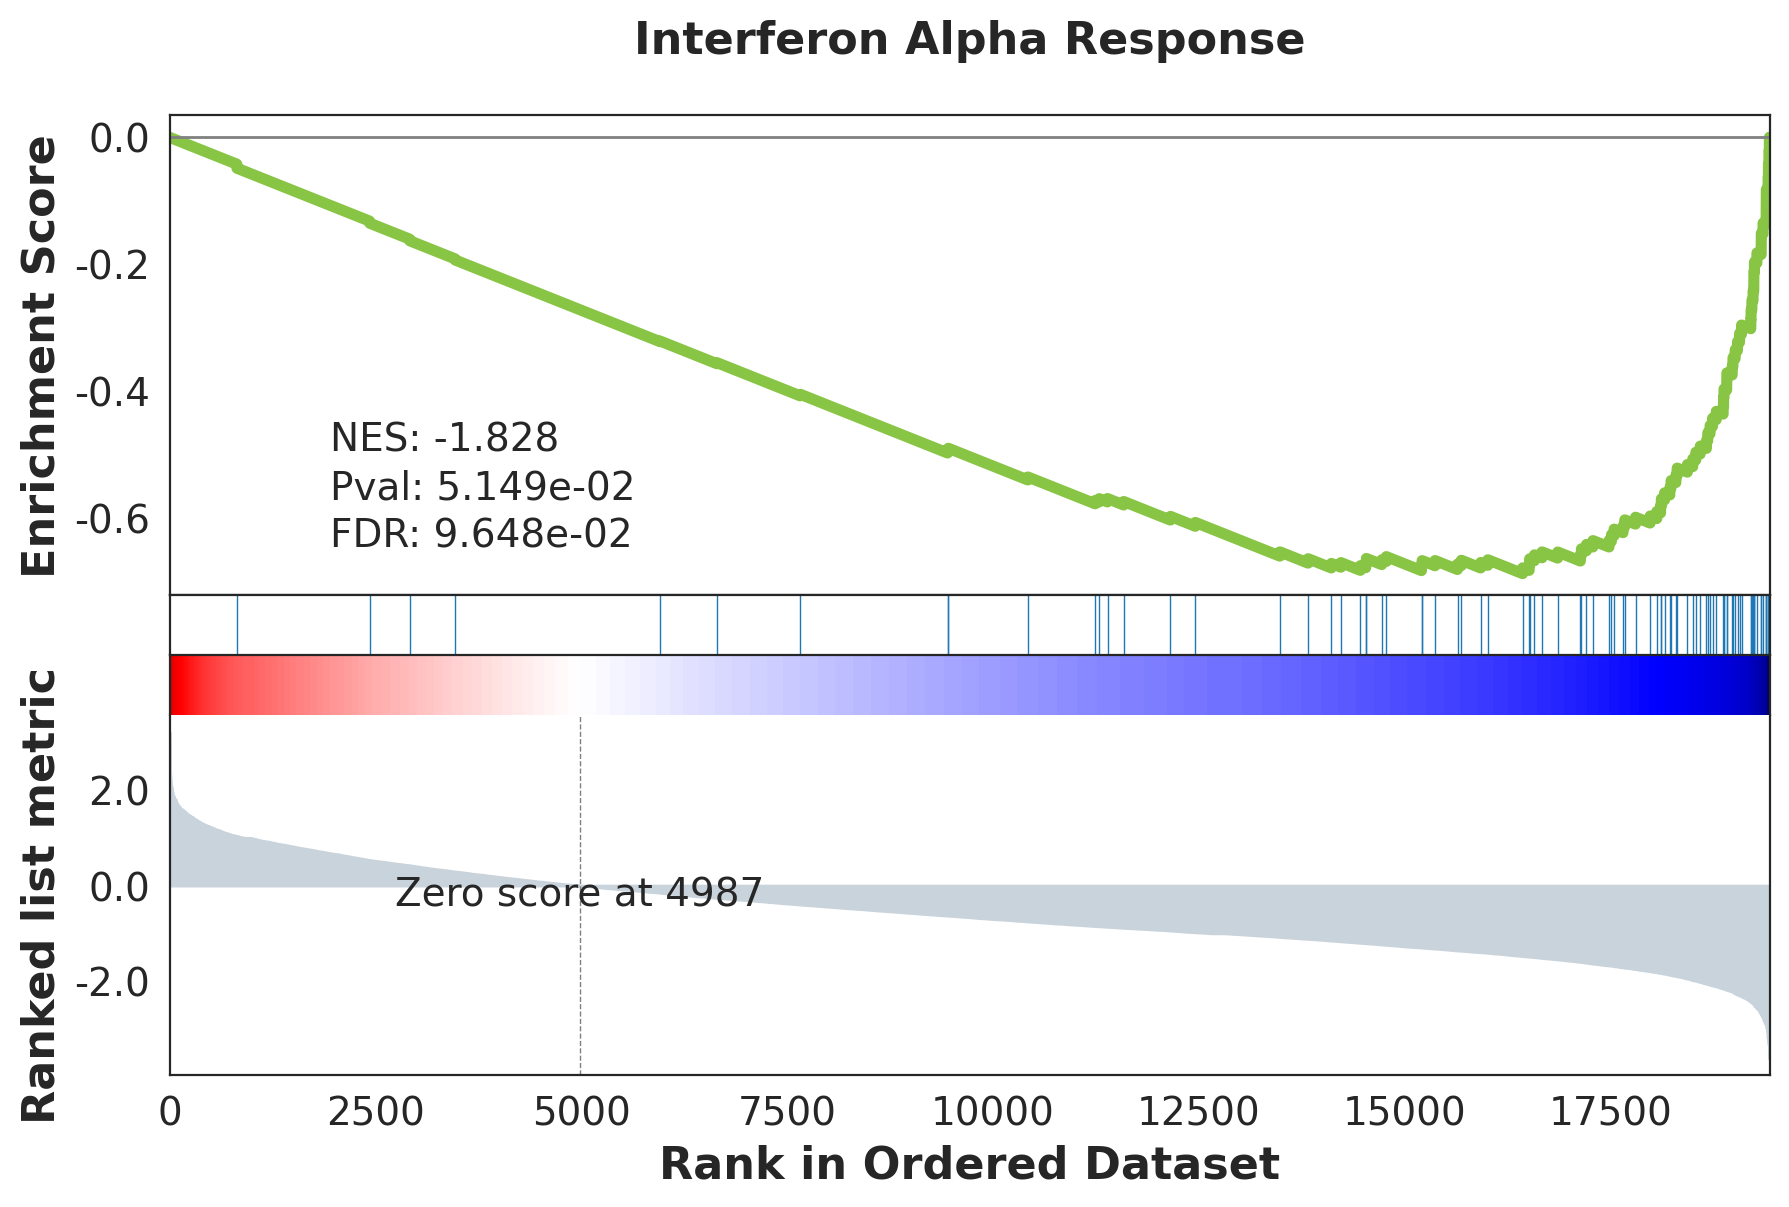

In [185]:
from gseapy import gseaplot
gseaplot(rank_metric=gs_res.ranking,
         term=terms[1],
         **gs_res.results[terms[1]], figsize=(10,6),)
plt.show()

# Hypoxia x JAK-STAT in EOC

In [186]:
hyp_jakstat = pd.read_csv('/mnt/storageBig8/work/afenteva/ChemoRef/PAPER_v2/copyp.tsv',
                   sep='\t', index_col=0)

In [181]:
status_palette = {'Refractory': '#f28482',
                  'Responsive': '#81b29a',
                  'Intermediate': '#70A5CE'}

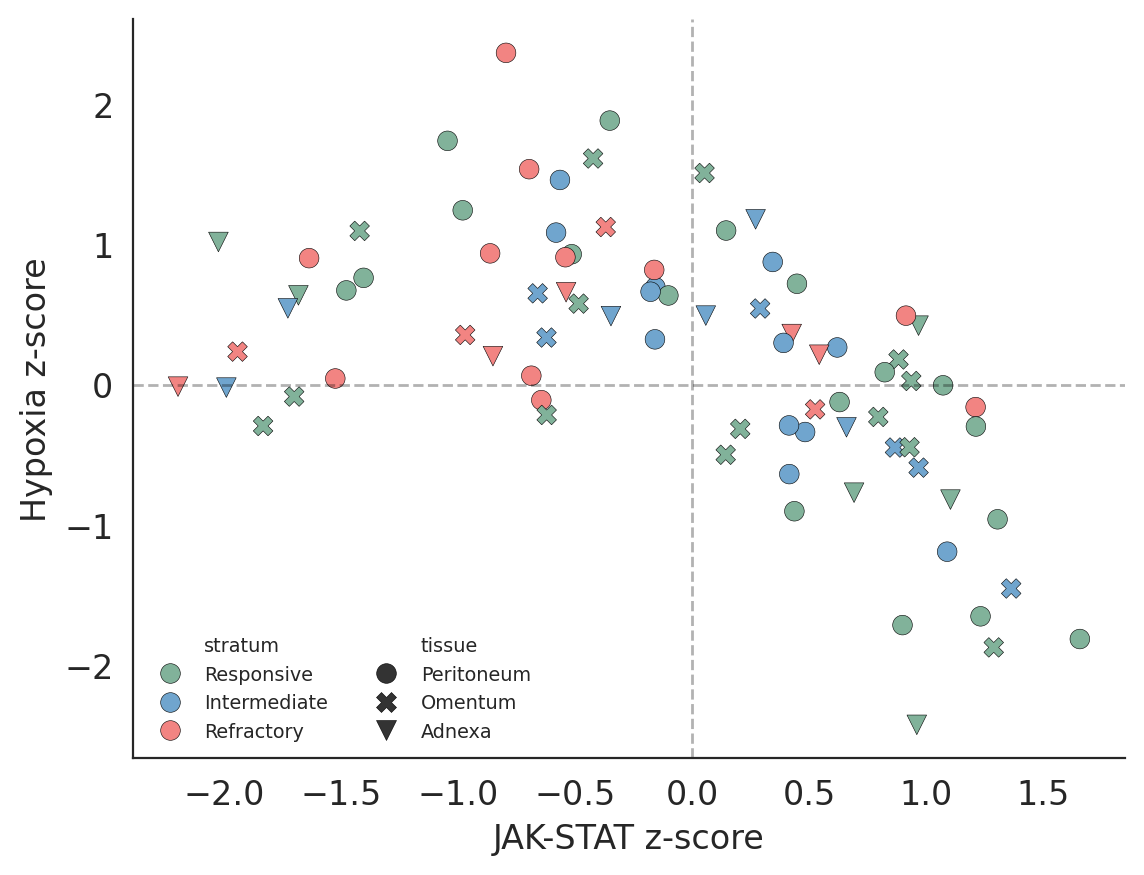

In [189]:
scatter_plot = sns.scatterplot(data=hyp_jakstat,
                x='JAK-STAT',
                y='Hypoxia',
                style='tissue',
                markers=['o','X', 'v'],
                hue='stratum',
                palette=status_palette, alpha=1,
                edgecolor='black', linewidth=0.2,
                legend=True, s=50
               )

plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
legend = plt.legend(title='', loc='lower left',
                    frameon=True, framealpha=0, fontsize='xx-small', ncol=2)
plt.xlabel('JAK-STAT z-score')
plt.ylabel('Hypoxia z-score')

spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    scatter_plot.spines[spine].set_visible(False)

plt.show()

# CycIF

In [198]:
cycif = pd.read_csv('/mnt/storageBig8/work/afenteva/ChemoRef/PAPER/cycif_four_patients.tsv',
            sep='\t', index_col=0)

/tmp/ipykernel_3291965/3555978824.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['EOC3', 'EOC87', 'EOC933', 'EOC940'],


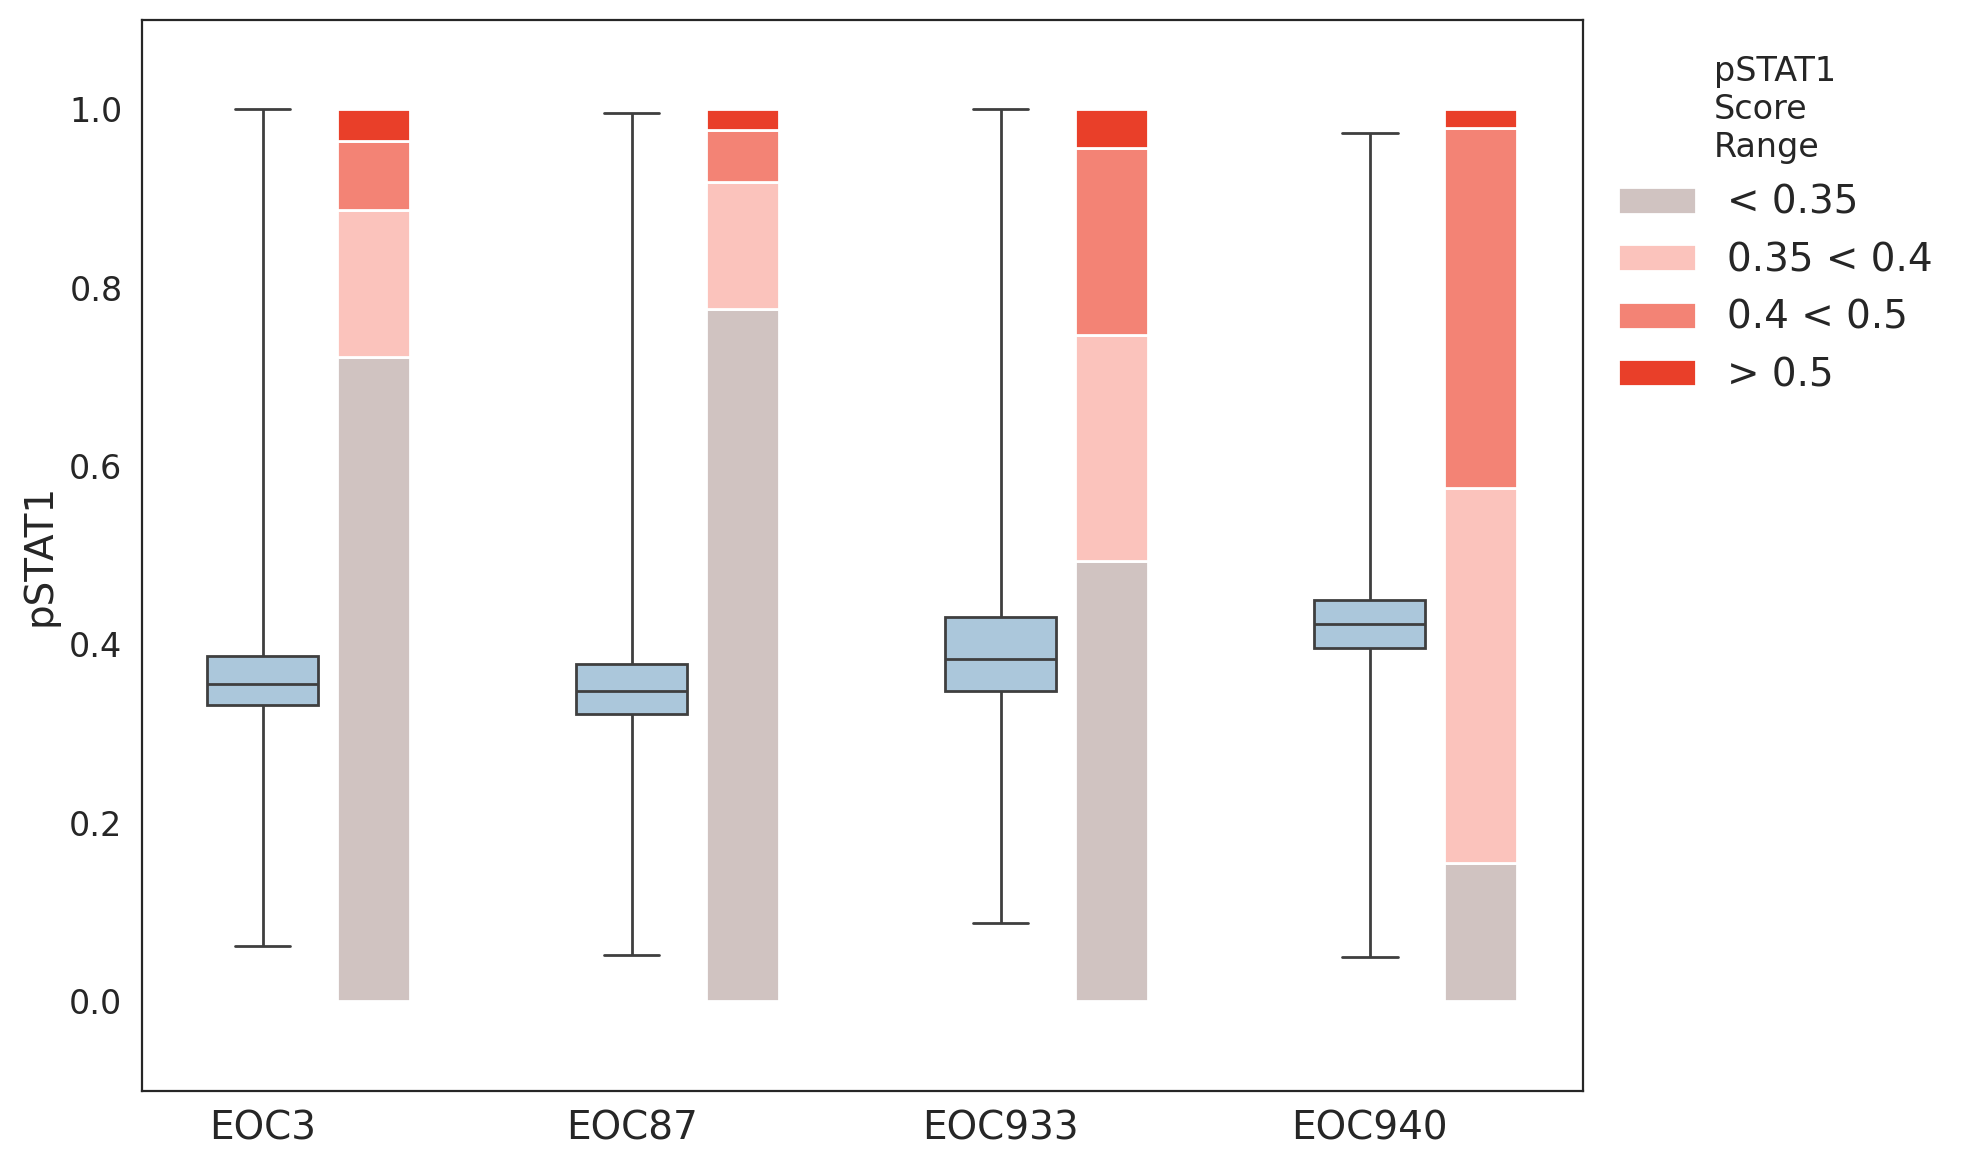

In [203]:
sns.set_style("white")

df = cycif[cycif.GlobalCellType2 == 'Tumor'].copy()

df['sample'] = pd.Categorical(df['patient'],
                              categories=['EOC3', 'EOC87', 'EOC933', 'EOC940'],
                              ordered=True)
df = df.sort_values(by='sample')

# Scale the JAK-STAT scores to be between 0 and 1
df['pSTAT1_scaled'] = (df['pSTAT1'] - df['pSTAT1'].min()) / (df['pSTAT1'].max() - df['pSTAT1'].min())

# Define JAK-STAT score ranges
df['pSTAT1_range'] = pd.cut(df['pSTAT1_scaled'],
                              bins=[-np.inf, 0.35, 0.4, 0.5, np.inf],
                              labels=['< 0.35', '0.35 < 0.4', '0.4 < 0.5', '> 0.5'])

bar_colors = {
    '< 0.35': '#D0C3C1',
    '0.35 < 0.4': '#FBC3BC',
    '0.4 < 0.5': '#F38375',
    '> 0.5': '#E93F29'
}

# Calculate proportions for the stacked bar plot
proportions = df.pivot_table(index='patient',
                             columns='pSTAT1_range',
                             aggfunc='size',
                             fill_value=0,
                             sort=False)
proportions = proportions.div(proportions.sum(axis=1), axis=0)  # Convert counts to proportions

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as needed

ax = sns.boxplot(x='patient', y='pSTAT1', data=df,
               ax=ax, order=['EOC3', 'EOC87', 'EOC933', 'EOC940'],
               width=0.3, #palette=patient_color,
            saturation=0.8, fliersize=2, linewidth=1, whis=25)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.4))

# Plot the stacked bar plot with an offset to the right (+0.2 in this case)

proportions = proportions.loc[['EOC3', 'EOC87', 'EOC933', 'EOC940']]

bottom = np.zeros(len(proportions))
bar_positions = np.arange(len(proportions)) + .3  # Offsetting bar positions to the right
bar_width = 0.2  # Width of the bars in the bar plot

for category in proportions.columns:
    ax.bar(bar_positions, proportions[category],
           bottom=bottom, label=category, width=bar_width,
           color=bar_colors[category],)
    bottom += proportions[category].values

# Customizing the plot to make it publication-quality
ax.set_xlabel('')
ax.set_ylabel('pSTAT1', fontsize=14)
ax.legend(title='pSTAT1\nScore\nRange', fontsize=14, title_fontsize=12,
          frameon=False, loc='upper left', alignment='center', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
ax.set_ylim(bottom=-0.1,top=1.1)
ax.set_xticklabels(['EOC3', 'EOC87', 'EOC933', 'EOC940'],
                   rotation=0, fontsize=14)

# Tight layout often produces nicer spacing between plots and labels
plt.tight_layout()

# Show the plot
plt.show()

In [210]:
# cycif.drop(columns=['Sample_code', 'yH2AX']).to_csv('/mnt/storageBig8/work/afenteva/ChemoRef/PAPER/CycIF_for_review.tsv',
#                                          sep='\t')